In [46]:
import yfinance as yf
import pandas as pd
import numpy as np

data = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01")
data.dropna(inplace=True)

C:\Users\ASHWIN\AppData\Local\Temp\ipykernel_15144\3906448775.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [47]:
#Ichimoku Cloud Lines(Momentum Indicator)
data['tenkan'] = (data['High'].rolling(9).max() + data['Low'].rolling(9).min()) / 2

data['kijun'] = (data['High'].rolling(26).max() + data['Low'].rolling(26).min()) / 2

data['senkou_a'] = ((data['tenkan'] + data['kijun']) / 2).shift(26)

data['senkou_b'] = ((data['High'].rolling(52).max() + data['Low'].rolling(52).min()) / 2).shift(26)

In [48]:
#Ease of movement indicator(Volume Indicator)
distance = ((data['High'] + data['Low']) / 2) - ((data['High'].shift(1) + data['Low'].shift(1)) / 2)
box_ratio = data['Volume'] / (data['High'] - data['Low'])

data['EOM'] = distance / box_ratio
data['EOM_14'] = data['EOM'].rolling(14).mean()

In [49]:
#Keltner Channels(Volatility Indicator)
ema = data['Close'].ewm(span=20).mean()
atr = (data['High'] - data['Low']).rolling(14).mean()

data['Upper_KC'] = ema + 2 * atr
data['Lower_KC'] = ema - 2 * atr

In [50]:
data.dropna(inplace=True)

In [51]:
#Signal Generation
import numpy as np

n = len(data)

close = data['Close'].to_numpy().reshape(n)
upper_kc = data['Upper_KC'].to_numpy().reshape(n)
lower_kc = data['Lower_KC'].to_numpy().reshape(n)
eom = data['EOM_14'].to_numpy().reshape(n)

senkou_a = data['senkou_a'].to_numpy().reshape(n)
senkou_b = data['senkou_b'].to_numpy().reshape(n)

signal = np.zeros(n, dtype=int)

buy_condition = (
    (close > senkou_a) &
    (close > senkou_b) &
    (close > upper_kc) &
    (eom > 0)
)

sell_condition = (
    (close < senkou_a) &
    (close < senkou_b) &
    (close < lower_kc) &
    (eom < 0)
)

signal[buy_condition.astype(bool)] = 1
signal[sell_condition.astype(bool)] = -1

data['signal'] = signal

In [52]:
# Risk management
stop_loss = 0.05
take_profit = 0.10

close_prices = data['Close'].values
signals = data['signal'].values

entry_price = 0.0
in_position = False

exit_signal = np.zeros(len(data))

for i in range(len(data)):
    if signals[i] == 1 and not in_position:
        entry_price = close_prices[i]
        in_position = True

    elif in_position:
        price_change = (close_prices[i] - entry_price) / entry_price

        if price_change <= -stop_loss or price_change >= take_profit or signals[i] == -1:
            exit_signal[i] = -1
            in_position = False

data['exit_signal'] = exit_signal

In [54]:
# Position Column
position = np.zeros(len(data))

for i in range(len(data)):
    if data['signal'].iloc[i] == 1:
        position[i] = 1
    elif data['exit_signal'].iloc[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1] if i > 0 else 0

data['position'] = position

In [55]:
#Backtesting
initial_capital = 100000

data['market_returns'] = data['Close'].pct_change()
data['strategy_returns'] = data['position'].shift(1) * data['market_returns']

data = data.dropna().copy()

data['portfolio_value'] = initial_capital * (1 + data['strategy_returns']).cumprod()

In [56]:
#Net profit
if 'portfolio_value' not in data.columns or len(data) == 0:
    final_value = initial_capital
else:
    final_value = data['portfolio_value'].values[-1]

net_profit = final_value - initial_capital

print("Final Portfolio Value:", round(final_value, 2))
print("Net Profit:", round(net_profit, 2))

Final Portfolio Value: 262349.35
Net Profit: 162349.35


In [57]:
#Sharpe ratio
returns = data['strategy_returns'].values

risk_free_rate = 0.01 / 252

mean_return = returns.mean()
std_return = returns.std()

sharpe_ratio = ((mean_return - risk_free_rate) / std_return) * np.sqrt(252) if std_return != 0 else 0

print("Sharpe Ratio:", round(sharpe_ratio, 2))

Sharpe Ratio: 1.12


In [58]:
#Sortino Ratio
downside_returns = returns[returns < 0]

sortino_ratio = (
    (mean_return / downside_returns.std()) * np.sqrt(252)
    if len(downside_returns) > 0 and downside_returns.std() != 0
    else 0
)

print("Sortino Ratio:", round(sortino_ratio, 2))

Sortino Ratio: 1.14


In [59]:
#Maximum Drawdown
rolling_max = data['portfolio_value'].cummax()
drawdown = (data['portfolio_value'] - rolling_max) / rolling_max

max_drawdown = drawdown.min() * 100

print("Maximum Drawdown (%):", round(max_drawdown, 2))

Maximum Drawdown (%): -21.33


In [60]:
#No. of winning and losing trades
trade_returns = data.loc[data['exit_signal'] == -1, 'strategy_returns']

winning_trades = (trade_returns > 0).sum()
losing_trades = (trade_returns < 0).sum()
total_trades = winning_trades + losing_trades

win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

print("Total Trades:", total_trades)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Win Rate (%):", round(win_rate, 2))

Total Trades: 23
Winning Trades: 13
Losing Trades: 10
Win Rate (%): 56.52


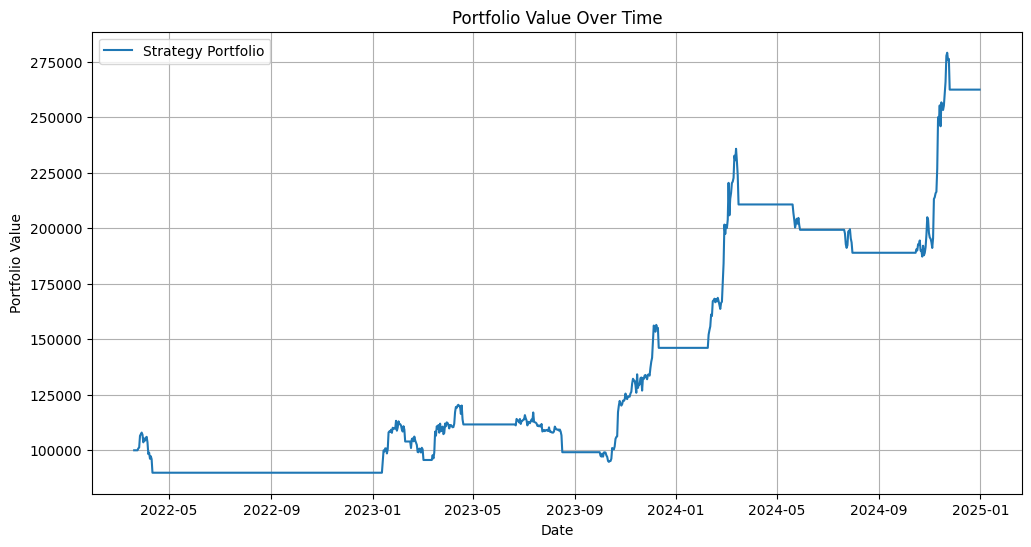

In [61]:
#Graph of Portfolio Value over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['portfolio_value'], label='Strategy Portfolio')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

#Documentation

Asset: Bitcoin(BTC)

Period: 01-01-2022 to 01-01-

Timeframe: Daily

Indicators used: Ichimoku Cloud lines,Ease of movement indicator,Keltner Channels

**Strategy :

*Buy signal:
-Price is above the ichimoku cloud
-EOM is positive
-Price is above the upper keltner channel

*Sell signal:
-Price is below the ichimoku cloud
-EOM is negative
-Price is below the lower keltner channel

**Risk Management:

A stop loss of 5% is applied to each trade to automatically exit the position if the price moves against the trade beyond a predefined level.This helps limit the downside risk.

**Backtesting:

All buy and sell signals are applied to the data,and trade outcomes are recorded.First market rreturns are calculated using rhe percentage change of the closing price.Strategy returns are then computed by multiplying these market returns by the trading position from the previous period.The portfolio value is calculated by compounding the strategy returns over time and scaling them by the initial capital,which tell how gains and losses accumulate throughout the trading period.

